In [1]:
#  If using google drive, uncomment these 2 lines for accessing your myDrive folder
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# packages imports: 

import pandas as pd
from decimal import Decimal
%load_ext autoreload
%autoreload 2
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

# setting a seed to reproduce
seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split            
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences

#The data
corpus_root = 'books/'

# Enter here your local path to labelled data
PATH = ''

In [3]:
# loading the train data
df_train= pd.read_csv(PATH + "Content_Train_Label.csv",dtype=str)
df_train.head(2)

,Unnamed: 0,content_no_custom_words,green_content
0,0,betriebsmitarbeiter/in betriebsmitarbeiter/i...,0.0
1,1,responsibilities: provides health care and ass...,1.0


In [4]:
# making sure the green_content is not a string but an integer
df_train['green_content']=df_train['green_content'].replace({'0.0': 0, '1.0': 1})
df_train.head(2)

,Unnamed: 0,content_no_custom_words,green_content
0,0,betriebsmitarbeiter/in betriebsmitarbeiter/i...,0
1,1,responsibilities: provides health care and ass...,1


In [5]:
#loading the validation dataset
df_validate=pd.read_csv(PATH + "Content_Validation_Label.csv")
df_validate['green_content']=df_validate['green_content'].astype(int)
df_validate.head(2)

,content_no_custom_words,green_content
0,this is your opportunity to join swiss re grou...,0
1,chauffeur b (nur für pensionierte) chauffeur...,0


In [6]:
# test:
df_test=pd.read_csv(PATH + "Test_Final.csv")
df_test.head(2)

,title,content_no_custom_words,title_tokens,content_tokens,manual green
0,Business Process Engineers / Software Entwickl...,business process engineers / software entwickl...,"['business', 'process', 'engineer', 'software'...","['business', 'process', 'engineer', 'software'...",0
1,Kranführer/in mit SUVA Ausweis,kranführer/in mit suva ausweis kranführer/in...,"['kranführer', 'suva', 'ausweis']","['kranführer', 'suva', 'ausweis', 'kranführer'...",0


In [ ]:
# function that will help us create our embedding matrix:

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
# creating our matrix from text:

# train matrix: 
CNN_df_train=df_train
CNN_df_train['sentence']= df_train['content_no_custom_words']
CNN_df_train=CNN_df_train[['sentence']] # selecting the columsn needed

sentences_train = CNN_df_train['sentence'].values # grouping the test 

# our response vector
Y_train = df_train['green_content'].values #

# here we say test but essentially it's validation:

CNN_df_val=df_validate
CNN_df_val['sentence']= df_validate['content_no_custom_words']
CNN_df_val=CNN_df_val[['sentence']]

sentences_val = CNN_df_val['sentence'].values
Y_val = df_validate['green_content'].values

# tokenising our sentences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1                          

# setting the max length of our sentences
maxlen = 4084

# padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [ ]:
# test matrix: 
CNN_df_test=df_test
CNN_df_test['sentence']= df_test['content_no_custom_words']
CNN_df_test=CNN_df_test[['sentence']] # selecting the columsn needed

sentences_test = CNN_df_test['sentence'].values # grouping the test

# tokenising our sentences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_test)

X_test= tokenizer.texts_to_sequences(sentences_test)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#fixing the dimensions
Y_val=Y_val.reshape((len(Y_val), 1))
Y_train=Y_train.reshape((len(Y_train), 1))

In [ ]:
# verfying the dimensions
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape,X_test.shape)

(18176, 4084) (18176, 1) (300, 4084) (300, 1) (300, 4084)


In [ ]:
# creating our neural networks and adding the layers:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model1 = Sequential() # sequential one after the other
model1.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1.add(layers.Conv1D(128, 5, activation='relu'))
model1.add(layers.GlobalMaxPooling1D()) # pooling
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train, Y_train,epochs=10,validation_data=(X_val, Y_val), batch_size=10)

Epoch 1/10
1818/1818 [==============================] - 61s 29ms/step - loss: 0.1159 - accuracy: 0.9639 - val_loss: 0.7696 - val_accuracy: 0.8733
Epoch 2/10
1818/1818 [==============================] - 52s 28ms/step - loss: 0.0333 - accuracy: 0.9905 - val_loss: 1.2189 - val_accuracy: 0.8667
Epoch 3/10
1818/1818 [==============================] - 52s 28ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 1.4368 - val_accuracy: 0.8700
Epoch 4/10
1818/1818 [==============================] - 52s 28ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 1.6501 - val_accuracy: 0.8700
Epoch 5/10
1818/1818 [==============================] - 51s 28ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 2.3671 - val_accuracy: 0.8667
Epoch 6/10
1818/1818 [==============================] - 51s 28ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 2.4827 - val_accuracy: 0.8700
Epoch 7/10
1818/1818 [==============================] - 52s 28ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 2.7951 -

In [ ]:
y_pred = model1.predict(X_test)

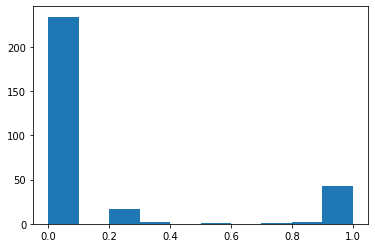

In [ ]:
plt.hist(y_pred)
plt.show()

In [ ]:
# function to go from probablities to binary classification
def predict_labels(y,thres):
    """Generates class predictions given weights, and a test data matrix"""
    y[np.where(y <= thres)] = 0
    y[np.where(y > thres)] = 1
    
    return y

In [ ]:
y_pred_binary1=predict_labels(y_pred,0.5) # setting the threshold

In [ ]:
y_pred_binary1

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],

In [ ]:
df_test['content_prediction'] = y_pred_binary1
df_test.to_csv(PATH + 'Content_Prediction_VectCNN.csv', index=False)

In [ ]:
# metrics to test our results:

def compute_0_1(train_data, prediction):
    bool_temp=np.equal(train_data,prediction)
    fraction=sum(bool_temp)
    n=train_data.shape[0]
    ratio_classified=fraction/n
    return(1-ratio_classified)

def calculate_accuracy(true_values, predictions):
    N=true_values.shape[0]
    accuracy = (true_values == predictions).sum() / N
    return (accuracy)
    
def calculate_precision(true_values, predictions):
    accuracy = calculate_accuracy(true_values, predictions)
    TP = ((predictions == 1) & (true_values == 1)).sum()
    FP = ((predictions == 1) & (true_values == 0)).sum()
    precision = TP / (TP+FP)
    return(precision)
    
def calculate_sensitivity(true_values, predictions):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for t,p in zip(true_values, predictions):
       if t == p:
           if p == 1:
               tp += 1
           else:
               tn += 1
       else:
           if p == 1:
               fn += 1
           else:
               fp += 1
    return(tp, tn, fp, fn) 
    
    
    
def calculate_recall(true_values, predictions):
    tp, tn, fp, fn = calculate_sensitivity(true_values, predictions) 
    return(tp/ (tp + fn))
    
    
def calculate_F1(true_values, predictions):
            precision= calculate_precision(true_values, predictions)
            recall=  calculate_recall(true_values, predictions)
            f1= 2 * precision * recall / (precision + recall)
            return(f1)

In [ ]:
train_data=Y_test
prediction=y_pred_binary1
true_values=Y_test
predictions=y_pred_binary1

In [ ]:
zero_one= compute_0_1(train_data, prediction)

accuracy=calculate_accuracy(true_values, predictions)
   
    
precision= calculate_precision(true_values, predictions)
    
[tp, tn, fp, fn]=calculate_sensitivity(true_values, predictions)
# (tp, tn, fp, fn) 
    
    
    
recall = calculate_recall(true_values, predictions)
    
f1= calculate_F1(true_values, predictions)

print("The 0-1 score is of {}, the accuracy is of {}, \n we have {} true positve, {} true negative, {} false positive, {} false negative, \n the recall is of {} and the f1 score is of {}.". format(zero_one,accuracy,precision,tp, tn, fp, fn,recall,f1))

The 0-1 score is of [0.13666667], the accuracy is of 0.8633333333333333, 
 we have 0.38333333333333336 true positve, 23 true negative, 236 false positive, 4 false negative, 
 the recall is of 37 and the f1 score is of 0.38333333333333336.
